In [1]:
!pip install selenium
!pip install wordcloud

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import csv
import requests
from bs4 import BeautifulSoup
import re
import pprint
from selenium import webdriver
import time
import random

In [3]:
pp = pprint.PrettyPrinter(indent=4)
 
def get_url(url):
    sleep_seconds = 8+ random.randint(0,10)
    print('sleep',sleep_seconds)
    time.sleep(sleep_seconds)
    
    driver = webdriver.PhantomJS(executable_path='./phantomjs-1.9.2-macosx/bin/phantomjs')
    driver.get(url)
    driver.implicitly_wait(1)
    cookies = driver.get_cookies()
    content = driver.page_source.encode('utf-8')
#     print(content)
    return content
#     except:
#         print('wrong!!!!!!!!!!!!!')

In [4]:
def getShopDistrict(url):
    html = get_url(url);
    soup = BeautifulSoup(html,'html.parser')
    divs = soup.find_all('div',attrs = {'class':'breadcrumb'})
    print(divs)
    district = divs[0].find_all('a')[1]
    print(district.text)

In [5]:
def getShopDetail(url):
    
    html = get_url(url)
    soup = BeautifulSoup(html,'html.parser')
    top_15 = soup.find_all('ul',attrs = {'class':'detail'})
    result = []    
    
    for i in top_15:
        shopname = i.find_all('a', attrs = {'class': 'BL'})[0]
        address = i.find_all('li', attrs= {'class': 'address'}) 
        addr = address[0].text.strip().split('\n')
        tags = [tag for tag in  i.find_all('li', attrs = {'class': 'tags'})]
        features = [feature for feature in  i.find_all('li', attrs = {'class': 'features'})]
        single_result = {
            'shopName': shopname.get_text(),
            'shopTitle': shopname['title'],
            'shopHref': 'http://www.dianping.com' + shopname['href'],
            'shopAddress': addr[0],
            'shopPhone': addr[1].strip(),
            'tags' : [ single.text  for j in tags for single in  j.find_all('a')],
            'features': [ single.text  for j in features for single in j.find_all('a')],
#             'district': getShopDistrict('http://www.dianping.com' + shopname['href'])
        } 
        result.append(single_result)
    return result;

In [6]:
import json

# 用于持久化结果到文件

def dumpRawData(filename, data):
    with open(filename,'w',encoding='utf-8') as f:
        json.dump(data,f)

In [7]:
def loadRawData(filename):
    with open(filename, 'r',encoding='utf-8') as f:
        result = json.load(f)
        return result;

In [8]:
def save_csv(filename, data):
    with open(filename + '.csv', "w",encoding='utf-8') as f:
        writer = csv.writer(f)
        for i in data:
            writer.writerows([[
                i['shopTitle'],
                i['shopName'],
                i['district'], 
                i['shopPhone'],
                i['shopHref'],
                ','.join(i['features']),
                ','.join(i['tags']),
                i['shopAddress']
            ]])
        f.close()

In [9]:
# 请求数据, 并保存到本地
temp = ["http://www.dianping.com/hongkong/food/p1", "http://www.dianping.com/hongkong/food/p2"]
result = []
for i in temp:
    result.extend(getShopDetail(i))
    
dumpRawData('result.txt', result)

sleep 13


/Users/yanglin/anaconda3/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


WebDriverException: Message: 'phantomjs' executable needs to be in PATH. 


In [ ]:
# 加载数据
rawData = loadRawData('result.txt')

for index,val in enumerate(rawData):
    print(index, val['shopTitle'],val['shopHref'], val['shopAddress'])

In [ ]:
# 获取地区
districts = [
    "尖沙咀/北京道/海港城", 
    "太平山顶/山顶道", 
    "湾仔/铜锣湾/鹅颈骆克道/Causeway Bay/景隆街", 
    "中环/上环", 
    "旺角/太子", 
    "油麻地/佐敦", 
    "沙田", 
    "香港国际机场", 
    "荃湾/青衣/葵涌石荫路", 
    "尖东/红磡", 
    "大角咀", 
    "观塘/九龙湾", 
    "元朗/天水围", 
    "九龙城", 
    "屯门", 
    "深水埗", 
    "土瓜湾",
    "南丫岛"
]
district_dict = {}
for index, value in enumerate(districts):
    for dis in value.split('/'):
        district_dict[dis] = index
print(district_dict)

In [ ]:
# 处理商圈
for index, i in enumerate(rawData):
    for k,v in district_dict.items():
        if k in i['shopAddress']:
            i['district'] = districts[v].split('/')[0]
            break;

In [ ]:
# 保存处理数据
save_csv('rawData.csv', rawData)

In [ ]:
# stroy 1 
tags_count = {}
for i in rawData:
    for tag in i['tags']:
        if tag not in tags_count:
            tags_count[tag] = 1
        else:
            tags_count[tag] = tags_count[tag] + 1
print(tags_count)

In [ ]:
# story 2 
features_count = {}
for i in rawData:
    for feature in i['features']:
        if feature not in features_count:
            features_count[feature] = 1
        else:
            features_count[feature] = features_count[feature] + 1
print(features_count)

In [ ]:
# story3
district_count = {}
for i in rawData:
    if i['district'] not in district_count:
        district_count[i['district']] = 1
    else:
        district_count[i['district']] = district_count[i['district']] + 1
print(district_count)

# What Can We Find about the Hong Kong Food in the DianPing's Website?

In [14]:
# 开始制图
%matplotlib inline
import matplotlib
import pandas
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['font.family']='sans-serif'

df = pandas.read_csv('rawData.csv.csv', header=None, 
                     names=[ 'shopTitle',
                'shopName',
                'district', 
                'shopPhone',
                'shopHref',
                'features',
                'tags',
                'shopAddress'])
df

,shopTitle,shopName,district,shopPhone,shopHref,features,tags,shopAddress
0,天龙轩,天龙轩,尖沙咀,+852-22632270,http://www.dianping.com/shop/5277130,"黑豚叉烧,窝贴大虾多士,杨枝甘露","粤菜,中餐",地址:尖沙咀柯士甸道西1号环球贸易广场(ICC)香港丽思卡尔顿酒店102楼
1,厨魔,厨魔,湾仔,+852-28508371,http://www.dianping.com/shop/5296971,"分子小笼包,佐贺牛排,松露汉堡包",更多美食,地址:湾仔庄士敦道60号船街 J-Senses 1楼8号铺
2,Sushi Tokami,Sushi Tokami,尖沙咀,27713938,http://www.dianping.com/shop/45345146,"金枪鱼大腹,海胆军舰,金枪鱼中腹",日本料理,地址:海港城海洋中心二阶216A号铺
3,Cafe 103,Cafe 103,尖沙咀,+852-22632270,http://www.dianping.com/shop/8071778,"甜点,龙虾,长脚蟹",自助餐,地址:尖沙咀柯士甸道西1号环球贸易广场香港丽思卡尔顿酒店103楼
4,supabowl,supabowl,湾仔,+852-35654379,http://www.dianping.com/shop/98810776,Coco Bowl,冰淇淋,地址:湾仔汕头街4号地下A1号铺
5,唐阁,唐阁,尖沙咀,+852-21327898,http://www.dianping.com/shop/2120596,"三葱爆龙虾,唐阁宝盒饭,焗蟹盖","粤菜,中餐",地址:尖沙咀北京道8号香港朗廷酒店1楼及2楼
6,桥底辣蟹,桥底辣蟹(谢斐道店),湾仔,00852-25737698,http://www.dianping.com/shop/2127967,"桥底辣蟹,濑尿虾,蒜蓉蛏子王","海鲜,中餐",地址:湾仔谢斐道414-424地下1-2号
7,禾牛荟火煱馆,禾牛荟火煱馆(尖沙咀店),尖沙咀,+852-39973369,http://www.dianping.com/shop/5683204,"手切新鲜牛肉,素翅冬瓜鸡汤底,现打虾滑",火锅,地址:尖沙咀金马伦道中国保险大厦1楼
8,大一海鲜火锅料理,大一海鲜火锅料理,尖沙咀,+852-28896986,http://www.dianping.com/shop/67020546,"黑松露带子饺,手工切本地牛肉,金汤腿翅锅",火锅,地址:香港九龙尖沙咀宝勒巷3-7A号万事昌广场2楼1室
9,喜记避风塘炒辣蟹,喜记避风塘炒辣蟹(湾仔总店),湾仔,+852-28937565,http://www.dianping.com/shop/24861445,"避风塘炒蟹,招牌炒蚬,干炒牛河",中餐,地址:湾仔谢斐道379号1-4号铺地下


# 1. What are the most popular food regions in Hong Kong?
## ‘Tsim Sha Tsui’, ‘wan chai’, ‘central’ rank the top three. But the Chinese characters in the chart don't work.

/Users/yanglin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


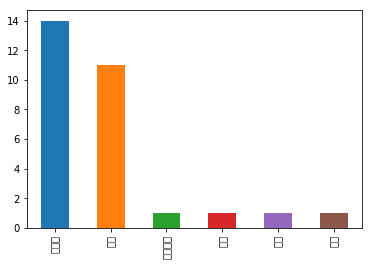

In [15]:
# 地区分布
df['district'][1:].value_counts().plot(kind='bar')

# 2.  What are some of the best foods people talk about inthese restaurant?

In [62]:
# 词云
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(200,300))
wc = WordCloud(
    background_color="white", #背景颜色
    max_words=400, #显示最大词数
    font_path="./FZSTK.TTF",  #使用字体
    min_font_size=15,
    max_font_size=50, 
    width=600,  #图幅宽度
    height = 400
    )
words  = [j for tag in df['features'] for j in tag.split(',')]
print(words)

wc.generate(','.join(words))
wc.to_file("pic.png")
plt.imshow(wc)
plt.axis("off")



['黑豚叉烧', '窝贴大虾多士', '杨枝甘露', '分子小笼包', '佐贺牛排', '松露汉堡包', '金枪鱼大腹', '海胆军舰', '金枪鱼中腹', '甜点', '龙虾', '长脚蟹', 'Coco Bowl', '三葱爆龙虾', '唐阁宝盒饭', '焗蟹盖', '桥底辣蟹', '濑尿虾', '蒜蓉蛏子王', '手切新鲜牛肉', '素翅冬瓜鸡汤底', '现打虾滑', '黑松露带子饺', '手工切本地牛肉', '金汤腿翅锅', '避风塘炒蟹', '招牌炒蚬', '干炒牛河', '招牌黄金蟹粥', '脆皮牛腩', '避风塘炒虾', '烧鹅', '酸姜皮蛋', '叉烧', '流沙包', '御寶濃湯大排翅', '鮑汁燜鳳爪', '薄烧和牛', '松露意面', '燒Tuna腩卷', '喜记正宗炒辣蟹', '椒盐濑尿虾', '清酒煮鲍鱼', '雪花牛肉', '手切牛肉', '象拔蚌', '阿甘虾儿童餐', '猪仔骨', '芝士海鲜饭', '鲍鱼', '招牌海鲜炒饭', '红酒酱炆牛尾', '奶茶', '咖喱牛腩饭', '猪仔包', '炒蟹', '避风塘炒赖尿虾', '炒蚬', '雞煲', '海鲜火锅', '生猛海鲜拼盘', '避风塘炒蟹', '黄金虾球', '南非鲜鲍鱼', '双层鹅肝牛肉汉堡', '旋风芝士薯条', '大烤菇芝士牛肉堡', '铁观音雪糕', '2DP素牛大啡菇漢堡', '半熟芝士焦糖炖蛋及云尼拿雪糕', '燒鱈場蟹腳', '蟹玉蒸蛋', '活毛蟹海鲜盛合', '金屋藏娇', '极上牛肉刺身', '芝士墨鱼丸', '姜米活鱼炒饭', '金汤焗龙虾', '濑尿虾', '冻奶茶', '咖喱牛腩饭', '鱼蛋河粉', '活貝漁獲浜燒盛合', '味噌蟹甲罗烧配多士', '香煎蒜片厚切牛舌', '燒薯牛柳粒', '千岛伴鬼马', '黃金蝦']


(-0.5, 599.5, 399.5, -0.5)

/Users/yanglin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# 3. What kind of food do people prefer to eat?
## Cantonese and Chinese food are the most popular choices, followed by seafood and hotpot. But the Chinese characters in the chart don't work.

{'粤菜': 9, '中餐': 10, '更多美食': 1, '日本料理': 4, '自助餐': 1, '冰淇淋': 2, '海鲜': 5, '火锅': 5, '西餐': 2, '茶餐厅': 3, '小吃快餐': 1, '汉堡': 1, '甜品': 1}


/Users/yanglin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


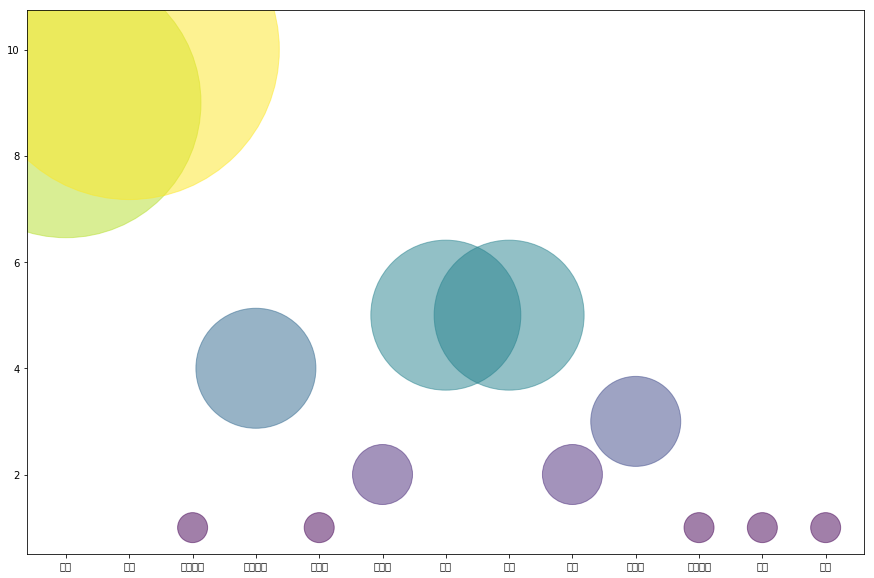

In [64]:
tags  = [j for tag in df['tags'] for j in tag.split(',')]
tags_count = {}
for tag in tags:
    if tag not in tags_count:
        tags_count[tag] = 1
    else:
        tags_count[tag] = tags_count[tag] + 1
print(tags_count)

x = []
y = []
area = []
colors = []
for k,v in tags_count.items():
    x.append(k)
    y.append(v)
    area.append((30 *  v) ** 2)
    colors.append(v) 
plt.figure(figsize=(15,10))
plt.scatter(x=x, y=y, s=area, c=colors, alpha=0.5)
plt.show()

## Question: How can I show the chinese characters in the chart?